In [1]:
import builtins
from datetime import datetime


def print(*args, **kwargs):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    builtins.print(f"[{timestamp}] ", *args, **kwargs)

In [2]:
import random

import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [31]:
ds = load_dataset("microsoft/cats_vs_dogs")
dataset2 = load_dataset("AI-Lab-Makerere/beans")

In [3]:
from datasets import load_dataset, concatenate_datasets

# Load dataset
dataset3 = load_dataset("timm/oxford-iiit-pet")

# Merge train and test into one dataset
full_dataset = concatenate_datasets([dataset3["train"], dataset3["test"]])

# Shuffle before splitting
full_dataset = full_dataset.shuffle(seed=42)

# Perform split: 80% train, 10% val, 10% test
train_val_test = full_dataset.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
val_test = train_val_test["test"].train_test_split(test_size=0.5, seed=42, stratify_by_column="label")

# Final DatasetDict
final_splits = {
    "train": train_val_test["train"],
    "validation": val_test["train"],
    "test": val_test["test"]
}

from datasets import DatasetDict
dataset = DatasetDict(final_splits)

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 5879
    })
    validation: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 735
    })
    test: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 735
    })
})

In [4]:
class cats_vs_dogs(Dataset):
    def __init__(self, dataset, transform, stage="train"):
        self.dataset = dataset
        self.transform = transform
        self.stage = stage
    def __len__(self):
        return len(self.dataset[self.stage])
        
    def __getitem__(self, idx):
        image = self.dataset[self.stage][idx]['image'].convert("RGB")
        label = int(self.dataset[self.stage][idx]['label'])
        
        label = torch.tensor(label).float()
        image = self.transform(image)
        
        return image, label

In [5]:
transform_config = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                             std=[0.26862954, 0.26130258, 0.27577711])
    ])
}

In [6]:
train_dataset = cats_vs_dogs(dataset, transform_config["train"], stage="train")
test_dataset = cats_vs_dogs(dataset, transform_config["test"], stage="test")
validation_dataset = cats_vs_dogs(dataset, transform_config["test"], stage="validation")

In [24]:
batch_size = 16 * 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [8]:
from torch import nn


class AlexNet(nn.Module):
    def __init__(self, num_classes, dropout: float = 0.5) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        if self.num_classes == 1:
            x = x.squeeze(1)
        return x

In [9]:
class VGG(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            *self.cnn_block(3, 64, 2),
            *self.cnn_block(64, 128, 2),
            *self.cnn_block(128, 256, 3),
            *self.cnn_block(256, 512, 3),
            *self.cnn_block(512, 512, 3),
        )              
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(4096, num_classes),
        )
        
    def cnn_block(self, in_channels, out_channels, nr_layers):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        
        for _ in range(nr_layers - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
        
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return layers
    
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        if self.num_classes == 1:
            x = x.squeeze(1)
        return x

In [10]:
import torch
import torch.nn as nn

# 1. Patch Embedding: Split image into non-overlapping patches and project them to an embedding space.
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        """
        img_size: size of the input image (assumed square).
        patch_size: size of each patch.
        in_chans: number of input channels (3 for RGB).
        embed_dim: dimension of the embedding space for each patch.
        """
        super().__init__()
        self.patch_size = patch_size
        # This convolution uses kernel size and stride equal to patch_size.
        # It converts the image into a grid of patches and projects each patch into an embedding vector.
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # Calculate the number of patches (e.g., for 224x224 with 16x16 patches, we have 14x14 = 196 patches)
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x has shape (batch_size, 3, 224, 224)
        x = self.proj(x)  # Now shape becomes (batch_size, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # Flatten the height and width dimensions; shape: (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # Transpose to shape: (batch_size, num_patches, embed_dim)
        return x

# 2. MLP Block: A simple feed-forward network used inside the mixer layers.
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.0):
        """
        in_features: size of each input vector.
        hidden_features: hidden layer dimension.
        out_features: size of the output vector.
        dropout: dropout rate applied after each linear layer.
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)  # First linear layer
        self.act = nn.GELU()  # Activation function
        self.fc2 = nn.Linear(hidden_features, out_features)  # Second linear layer
        self.drop = nn.Dropout(dropout)  # Dropout layer for regularization
        
    def forward(self, x):
        x = self.fc1(x)   # Apply first linear layer
        x = self.act(x)   # Apply GELU activation
        x = self.drop(x)  # Apply dropout
        x = self.fc2(x)   # Apply second linear layer
        x = self.drop(x)  # Apply dropout again
        return x

# 3. Mixer Layer: Contains both token mixing and channel mixing MLPs with residual connections.
class MixerLayer(nn.Module):
    def __init__(self, num_patches, embed_dim, token_mlp_dim, channel_mlp_dim, dropout=0.0):
        """
        num_patches: number of patches (tokens) per image.
        embed_dim: dimension of each patch embedding.
        token_mlp_dim: hidden dimension for the token-mixing MLP.
        channel_mlp_dim: hidden dimension for the channel-mixing MLP.
        dropout: dropout rate for the MLPs.
        """
        super().__init__()
        # Normalization before token mixing
        self.norm1 = nn.LayerNorm(embed_dim)
        # Token mixing MLP works across the tokens dimension. It first transposes the input.
        self.token_mixing = Mlp(num_patches, token_mlp_dim, num_patches, dropout)
        
        # Normalization before channel mixing
        self.norm2 = nn.LayerNorm(embed_dim)
        # Channel mixing MLP works on each token independently along the channel dimension.
        self.channel_mixing = Mlp(embed_dim, channel_mlp_dim, embed_dim, dropout)
        
    def forward(self, x):
        # x shape: (batch_size, num_patches, embed_dim)
        
        # ---- Token Mixing ----
        y = self.norm1(x)  # Normalize across the embedding dimension
        # Transpose to swap tokens and channels: shape becomes (batch_size, embed_dim, num_patches)
        y = y.transpose(1, 2)
        y = self.token_mixing(y)  # Mix information across the tokens (spatial locations)
        # Transpose back to original shape: (batch_size, num_patches, embed_dim)
        y = y.transpose(1, 2)
        # Add residual connection
        x = x + y
        
        # ---- Channel Mixing ----
        y = self.norm2(x)  # Normalize before channel mixing
        y = self.channel_mixing(y)  # Mix information along the channels for each token
        # Add residual connection
        x = x + y
        return x

# 4. MLP-Mixer Model: Stack the patch embedding, a series of Mixer layers, and the classification head.
class MLPMixer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1, embed_dim=768, depth=12, dropout=0.0):
        """
        img_size: size of the input image.
        patch_size: size of each patch.
        in_chans: number of image channels.
        num_classes: number of output classes (2 for cats vs. dogs).
        embed_dim: dimension of patch embeddings.
        depth: number of Mixer layers to stack.
        dropout: dropout rate for the MLP blocks.
        """
        super().__init__()
        self.num_classes = num_classes
        # Step 1: Patch Embedding
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        
        # Compute the number of patches (tokens)
        num_patches = self.patch_embed.num_patches  # For 224x224 and 16x16 patches, num_patches = 196
        
        # For the token-mixing MLP, the hidden dimension is set to the number of patches.
        token_mlp_dim = num_patches
        # For the channel-mixing MLP, the hidden dimension is 4 times the embedding dimension.
        channel_mlp_dim = embed_dim * 4
        
        # Step 2: Stack Mixer layers
        self.mixer_layers = nn.Sequential(*[
            MixerLayer(num_patches, embed_dim, token_mlp_dim, channel_mlp_dim, dropout)
            for _ in range(depth)
        ])
        
        # Step 3: Final normalization layer
        self.norm = nn.LayerNorm(embed_dim)
        
        # Step 4: Classification head.
        # After processing through Mixer layers, we perform global average pooling over tokens
        # and then project the resulting vector to the number of classes.
        self.classifier = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, 3, 224, 224)
        
        # Convert image to patch embeddings (tokens)
        x = self.patch_embed(x)  # Shape: (batch_size, num_patches, embed_dim)
        
        # Process the tokens through the Mixer layers
        x = self.mixer_layers(x)
        
        # Apply final layer normalization
        x = self.norm(x)
        
        # Global average pooling over the token dimension
        x = x.mean(dim=1)  # Now shape: (batch_size, embed_dim)
        
        # Final classifier to obtain logits for each class (cats vs. dogs)
        x = self.classifier(x)  # Shape: (batch_size, num_classes)
        if self.num_classes == 1:
            x = x.squeeze(1)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = AlexNet(num_classes=37)
# model.load_state_dict(torch.load("models/best_models/AlexNet_Best+lr=0.005+eta_min=0.0005+weight_decay=5e-05.pt"))
# Dummy input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-08-26 09:22:13]  tensor([[-0.0016,  0.0121,  0.0120, -0.0182, -0.0254, -0.0115, -0.0060,  0.0104,
          0.0038,  0.0111,  0.0145, -0.0192,  0.0010,  0.0020,  0.0140,  0.0295,
         -0.0016, -0.0224,  0.0299,  0.0073,  0.0109, -0.0117,  0.0130,  0.0027,
          0.0134, -0.0025,  0.0153, -0.0116, -0.0121,  0.0082,  0.0203,  0.0125,
         -0.0123, -0.0148,  0.0127,  0.0030,  0.0066],
        [ 0.0101,  0.0160,  0.0060, -0.0180, -0.0330,  0.0021, -0.0041, -0.0028,
         -0.0100,  0.0214, -0.0133, -0.0203, -0.0136, -0.0042,  0.0007,  0.0220,
         -0.0167, -0.0235,  0.0294,  0.0158,  0.0036, -0.0039,  0.0107, -0.0003,
          0.0071,  0.0085,  0.0213,  0.0023, -0.0054,  0.0098,  0.0050,  0.0155,
          0.0082, -0.0097,  0.0045,  0.0014,  0.0028]],
       grad_fn=<AddmmBackward0>)


In [13]:
model = VGG(num_classes=37, dropout=0.2)
# Dummy input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-08-26 09:22:14]  tensor([[ 0.0042,  0.0051,  0.0145, -0.0164,  0.0005,  0.0164,  0.0019, -0.0110,
          0.0105,  0.0153, -0.0090, -0.0073, -0.0022, -0.0077, -0.0159,  0.0100,
          0.0168,  0.0086,  0.0095,  0.0060, -0.0045,  0.0149,  0.0068,  0.0080,
         -0.0043, -0.0160,  0.0077,  0.0104, -0.0057, -0.0119, -0.0100,  0.0128,
          0.0002, -0.0089, -0.0181, -0.0050, -0.0047],
        [ 0.0080,  0.0038,  0.0152, -0.0116,  0.0033,  0.0107,  0.0111, -0.0090,
          0.0099,  0.0122, -0.0147, -0.0071, -0.0059, -0.0047, -0.0174,  0.0127,
          0.0159,  0.0097,  0.0091,  0.0027, -0.0072,  0.0140,  0.0070,  0.0100,
         -0.0003, -0.0195,  0.0111,  0.0119, -0.0050, -0.0126, -0.0095,  0.0109,
         -0.0025, -0.0110, -0.0218, -0.0066, -0.0086]],
       grad_fn=<AddmmBackward0>)


In [14]:
model = MLPMixer(img_size=224, patch_size=16, in_chans=3, num_classes=37, embed_dim=768, depth=12, dropout=0.1)
input_tensor = torch.randn(2, 3, 224, 224)
output = model(input_tensor)
print(output)

[2025-08-26 09:22:14]  tensor([[ 0.0397,  0.3190,  0.0902,  0.0752,  0.0266,  0.0858, -0.0758, -0.2346,
          0.0686,  0.0948,  0.0463,  0.0296, -0.1272,  0.0624, -0.1541,  0.0159,
         -0.0928, -0.1051, -0.0881, -0.1016, -0.0636,  0.1709,  0.1029, -0.1382,
          0.1322, -0.1066,  0.0117, -0.1933, -0.2188,  0.0476,  0.2647, -0.1538,
          0.2203,  0.0176,  0.1931, -0.1226,  0.0548],
        [ 0.0796,  0.3666,  0.0955,  0.1961, -0.0180,  0.0646, -0.0635, -0.2311,
          0.0969,  0.0659, -0.0883,  0.0726, -0.1871,  0.0019, -0.1273, -0.0686,
         -0.1667, -0.2447, -0.1586, -0.0367, -0.0319,  0.1679,  0.1244, -0.0906,
          0.1143, -0.1454, -0.0032, -0.1720, -0.1875,  0.1113,  0.2793, -0.2134,
          0.2363, -0.0578,  0.1906, -0.0903,  0.0943]],
       grad_fn=<AddmmBackward0>)


In [15]:
def initialize_weights(m):
    """
    Initializes the weights of the MLP-Mixer model.
    This function is applied recursively to all layers in the model.
    """
    if isinstance(m, nn.Linear):
        # Xavier Normal Initialization for Linear layers (MLPs)
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize bias to zero for stability
    
    elif isinstance(m, nn.LayerNorm):
        # Initialize LayerNorm (scale=1, bias=0)
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    
    elif isinstance(m, nn.Conv2d):
        # Kaiming Normal Initialization for the Patch Embedding layer (Conv2d)
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(initialize_weights)
model.to(device)

MLPMixer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (token_mixing): Mlp(
        (fc1): Linear(in_features=196, out_features=196, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=196, out_features=196, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (channel_mixing): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): MixerLayer(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (token_mixing): Mlp(
        (fc1): Linear(in_features=196, out_features=196, bias

In [16]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=5,
    T_mult=1,
    eta_min=5e-4,
)
model_config = {
    "lr": 1e-2,
    "eta_min": 5e-4,
    "weight_decay": 5e-4,
}

In [17]:
from sklearn.metrics import confusion_matrix as cf_mx
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names=None):
    if class_names is None:
        n = conf_matrix.shape[0]
        class_names = [str(i) for i in range(n)]
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

def validation_method(criterion, model, val_loader, show_confusion_matrix=False, class_names=None, device="cuda"):
    model.eval()
    validation_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            # labels must be LongTensor of shape [B] with values in [0..C-1]
            labels = labels.to(device).long()

            logits = model(images)                   # [B, C] raw scores
            loss = criterion(logits, labels)
            validation_loss += loss.item()

            preds = torch.argmax(logits, dim=1)      # [B]
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_loss = validation_loss / max(1, len(val_loader))

    # Metrics (macro treats all classes equally; use 'weighted' if imbalanced)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    if show_confusion_matrix:
        conf_matrix = cf_mx(all_labels, all_preds)
        plot_confusion_matrix(conf_matrix, class_names=class_names)

    return val_accuracy, val_f1, val_loss, val_precision, val_recall

In [18]:
from matplotlib import pyplot as plt
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time


def training_method(
    model, criterion, optimizer, scheduler,
    train_loader, val_loader, model_config,
    num_epochs=50, patience=15, delta=0.02, loss_percentage_improvement=10,
    model_name="vgg", class_names=None, device="cuda"
):
    train_losses, val_losses = [], []
    val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], []
    learning_rates = []

    best_val_loss = float('inf')
    initial_loss = float('inf')
    best_model = None
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        training_loss = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device).long()       # <-- ensure long dtype

            optimizer.zero_grad()
            logits = model(images)                   # [B, C]
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

            if len(train_loader) > 0 and batch_idx % max(1, (len(train_loader)//4)) == 0 and batch_idx != 0:
                print(f"[{epoch}, {batch_idx}/{len(train_loader)}] Loss: {training_loss / batch_idx:.4f}")

        train_loss = training_loss / max(1, len(train_loader))
        train_losses.append(train_loss)

        val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(
            criterion, model, val_loader, show_confusion_matrix=False, class_names=class_names, device=device
        )

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss - 1e-12:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            epochs_without_improvement = 0
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print("Validation loss did not improve significantly")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break

        # LR scheduler
        if scheduler is not None:
            scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        end_time = time.time()
        print(
            f"\nEpoch {epoch + 1}/{num_epochs} - "
            f"Training Loss: {train_loss:.4f} - "
            f"Validation Loss: {val_loss:.4f} - "
            f"Accuracy: {val_accuracy:.4f} - "
            f"Precision (macro): {val_precision:.4f} - "
            f"Recall (macro): {val_recall:.4f} - "
            f"F1 (macro): {val_f1:.4f} - "
            f"Time: {end_time - start_time:.2f}s - "
            f"Lr: {current_lr:.2e}"
        )

    print('Training finished!')

    # NOTE: your original save condition looked off. If you truly mean
    # "save if best_loss improved by X% over initial_loss", use division by 100.
    # Example below keeps your structure but fixes the math:
    improvement_factor = 1.0 - (loss_percentage_improvement / 100.0)
    if best_val_loss < improvement_factor * initial_loss:
        plt_save_path = f"models/{model_name}"
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved to {model_path}")

        # Plots
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training and Validation Loss'); plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision (macro)')
        plt.plot(val_recalls, label='Recall (macro)')
        plt.plot(val_f1s, label='F1 (macro)')
        plt.xlabel('Epochs'); plt.ylabel('Metric'); plt.title('Validation Metrics'); plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs"); plt.ylabel("Learning Rate"); plt.title("Learning Rate Progression"); plt.legend()

        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_percentage_improvement}%")
        # Plots
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Training and Validation Loss'); plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision (macro)')
        plt.plot(val_recalls, label='Recall (macro)')
        plt.plot(val_f1s, label='F1 (macro)')
        plt.xlabel('Epochs'); plt.ylabel('Metric'); plt.title('Validation Metrics'); plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs"); plt.ylabel("Learning Rate"); plt.title("Learning Rate Progression"); plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model

In [56]:
# best_model = training_method(model, criterion, optimizer, scheduler, train_dataloader, validation_dataloader, model_config, num_epochs=10, model_name="AlexNet")

In [57]:
# val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(criterion, best_model, validation_dataloader, show_confusion_matrix=True)

# Hyperparameter tuning

In [19]:
import gc, copy, random, numpy as np, torch
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

def hyperparameter_tuning(
    model_class,
    parameters_grid,
    epochs,
    train_dataloader,
    validation_dataloader,
    results,
    model_name="AlexNet",
    num_classes=37,
    class_names=None,
    device="cuda",
):
    best_model = None
    best_val_loss = np.inf

    for idx in tqdm(range(len(parameters_grid["lr"]))):
        # hyperparams (lr and eta_min paired by index; weight_decay sampled)
        lr = parameters_grid["lr"][idx]
        eta_min = parameters_grid["eta_min"][idx]
        weight_decay = random.choice(parameters_grid["weight_decay"])

        model_config = {"lr": lr, "eta_min": eta_min, "weight_decay": weight_decay}
        print(
            f"Learning rate {lr:.2e} - eta_min {eta_min:.2e} - weight_decay {weight_decay:.2e}"
        )

        try:
            # ---- model ----
            model = model_class(num_classes=num_classes)
            if model_name == "vgg":
                model.apply(initialize_weights)
            model.to(device)

            # ---- optim/scheduler ----
            criterion = CrossEntropyLoss()
            optimizer = torch.optim.SGD(
                model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=1, eta_min=eta_min
            )

            # ---- train ----
            best_curr_model = training_method(
                model,
                criterion,
                optimizer,
                scheduler,
                train_dataloader,
                validation_dataloader,
                model_config,
                num_epochs=epochs,
                model_name=model_name,
                class_names=class_names,
                device=device,
            )

            # ---- validate (no CM during tuning for speed) ----
            val_accuracy, val_f1, val_loss, val_precision, val_recall = validation_method(
                criterion,
                best_curr_model,
                validation_dataloader,
                show_confusion_matrix=False,
                class_names=class_names,
                device=device,
            )

            # ---- track best ----
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(best_curr_model)

            results.append(
                {
                    "lr": lr,
                    "eta_min": eta_min,
                    "weight_decay": weight_decay,
                    "val_loss": val_loss,
                    "val_accuracy": val_accuracy,
                    "val_precision_macro": val_precision,
                    "val_recall_macro": val_recall,
                    "val_f1_macro": val_f1,
                }
            )

        except RuntimeError as e:
            # e.g., CUDA OOM or other runtime errors for a config
            print(f"Error with configuration: lr={lr}, eta_min={eta_min}, weight_decay={weight_decay}")
            print(f"Error message: {str(e)}")

        finally:
            # Reset GPU memory between runs
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

    return best_model, results


# AlexNet

In [59]:
param_grid = {
    "lr":       [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    "eta_min":  [1e-4, 1e-4, 5e-5, 5e-5, 1e-5],
    "weight_decay": [5e-4, 1e-5, 5e-5]
}


total_combination = len(param_grid['lr'])
epochs = 100
time_per_epoch = 36 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-08-25 12:50:13]  Total time to hyper tune: 5.00 hours


In [60]:
AlexNet_results = []

  0%|          | 0/5 [00:00<?, ?it/s]

[2025-08-25 12:50:17]  Learning rate 1.00e-02 - eta_min 1.00e-04 - weight_decay 1.00e-05
[2025-08-25 12:50:26]  [0, 92/368] Loss: 3.6502
[2025-08-25 12:50:35]  [0, 184/368] Loss: 3.6333
[2025-08-25 12:50:43]  [0, 276/368] Loss: 3.6269
[2025-08-25 12:50:55]  New best model with Loss: 3.6085 at epoch 1
[2025-08-25 12:50:55]  
Epoch 1/100 - Training Loss: 3.6139 - Validation Loss: 3.6085 - Accuracy: 0.0354 - Precision (macro): 0.0029 - Recall (macro): 0.0351 - F1 (macro): 0.0053 - Time: 37.39s - Lr: 9.05e-03
[2025-08-25 12:51:03]  [1, 92/368] Loss: 3.6486
[2025-08-25 12:51:12]  [1, 184/368] Loss: 3.6249
[2025-08-25 12:51:21]  [1, 276/368] Loss: 3.6156
[2025-08-25 12:51:31]  New best model with Loss: 3.4952 at epoch 2
[2025-08-25 12:51:31]  
Epoch 2/100 - Training Loss: 3.5928 - Validation Loss: 3.4952 - Accuracy: 0.0599 - Precision (macro): 0.0204 - Recall (macro): 0.0596 - F1 (macro): 0.0232 - Time: 36.84s - Lr: 6.58e-03
[2025-08-25 12:51:40]  [2, 92/368] Loss: 3.5436
[2025-08-25 12:51:4

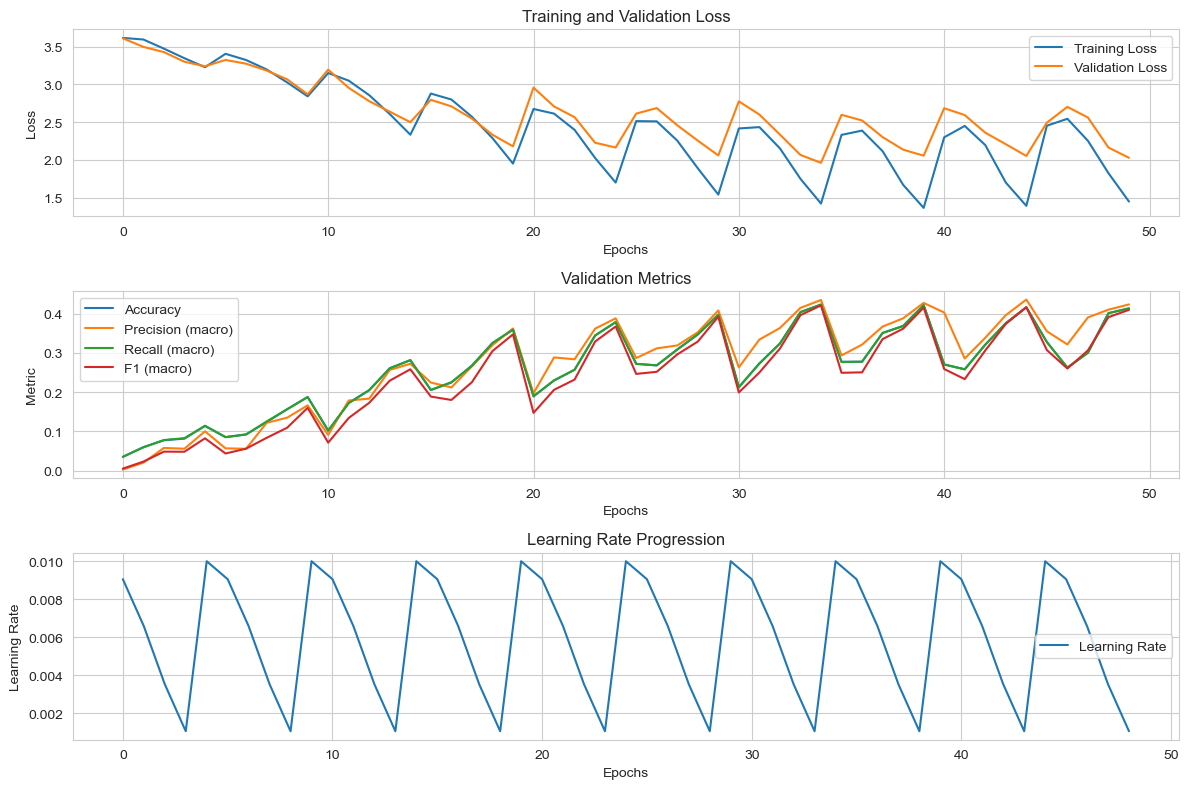

 20%|██        | 1/5 [30:39<2:02:39, 1839.91s/it]

[2025-08-25 13:20:57]  Resetting GPU memory...
[2025-08-25 13:20:57]  Learning rate 5.00e-03 - eta_min 1.00e-04 - weight_decay 5.00e-04
[2025-08-25 13:21:06]  [0, 92/368] Loss: 3.6512
[2025-08-25 13:21:15]  [0, 184/368] Loss: 3.6318
[2025-08-25 13:21:23]  [0, 276/368] Loss: 3.6254
[2025-08-25 13:21:34]  New best model with Loss: 3.6101 at epoch 1
[2025-08-25 13:21:34]  
Epoch 1/100 - Training Loss: 3.6127 - Validation Loss: 3.6101 - Accuracy: 0.0395 - Precision (macro): 0.0030 - Recall (macro): 0.0392 - F1 (macro): 0.0054 - Time: 37.11s - Lr: 4.53e-03
[2025-08-25 13:21:43]  [1, 92/368] Loss: 3.6494
[2025-08-25 13:21:51]  [1, 184/368] Loss: 3.6307
[2025-08-25 13:22:00]  [1, 276/368] Loss: 3.6241
[2025-08-25 13:22:11]  New best model with Loss: 3.6061 at epoch 2
[2025-08-25 13:22:11]  
Epoch 2/100 - Training Loss: 3.6111 - Validation Loss: 3.6061 - Accuracy: 0.0367 - Precision (macro): 0.0074 - Recall (macro): 0.0365 - F1 (macro): 0.0072 - Time: 36.80s - Lr: 3.31e-03
[2025-08-25 13:22:20

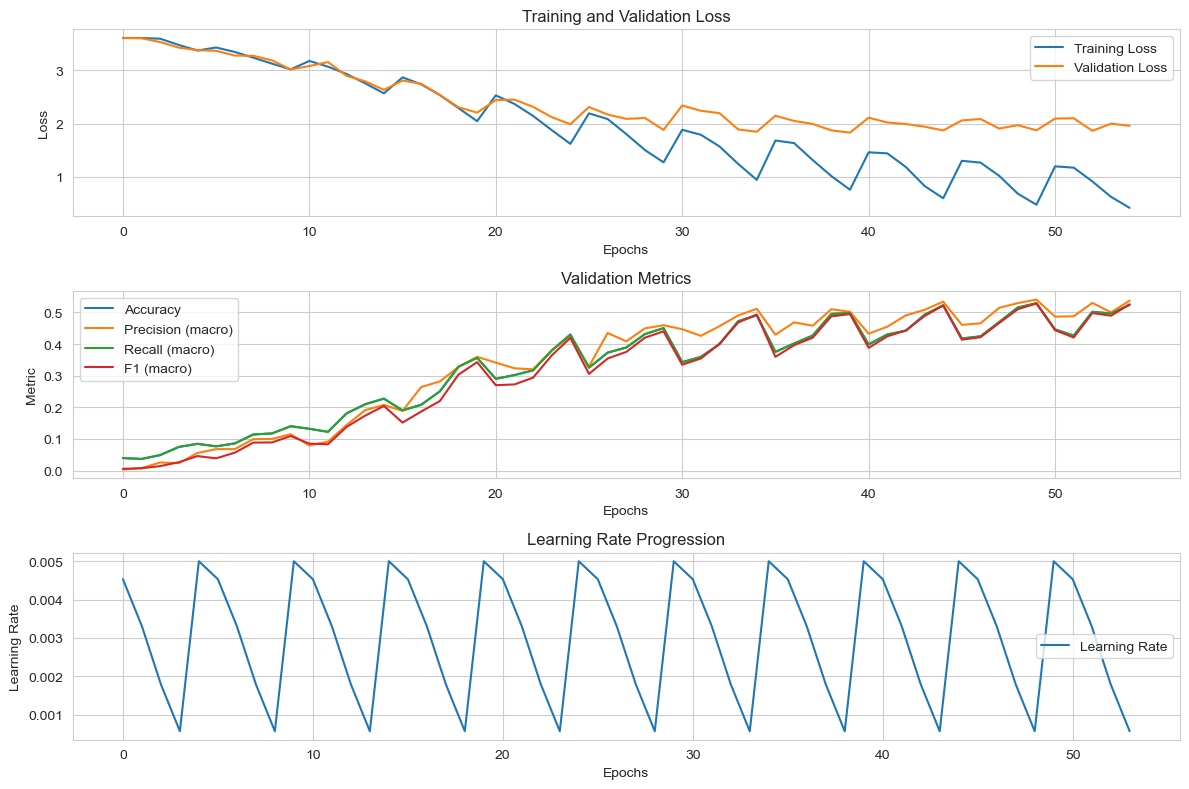

 40%|████      | 2/5 [1:04:28<1:37:32, 1950.68s/it]

[2025-08-25 13:54:45]  Resetting GPU memory...
[2025-08-25 13:54:45]  Learning rate 1.00e-03 - eta_min 5.00e-05 - weight_decay 1.00e-05
[2025-08-25 13:54:54]  [0, 92/368] Loss: 3.6502
[2025-08-25 13:55:03]  [0, 184/368] Loss: 3.6305
[2025-08-25 13:55:12]  [0, 276/368] Loss: 3.6244
[2025-08-25 13:55:23]  New best model with Loss: 3.6106 at epoch 1
[2025-08-25 13:55:23]  
Epoch 1/100 - Training Loss: 3.6114 - Validation Loss: 3.6106 - Accuracy: 0.0272 - Precision (macro): 0.0007 - Recall (macro): 0.0270 - F1 (macro): 0.0015 - Time: 37.65s - Lr: 9.09e-04
[2025-08-25 13:55:32]  [1, 92/368] Loss: 3.6502
[2025-08-25 13:55:41]  [1, 184/368] Loss: 3.6304
[2025-08-25 13:55:49]  [1, 276/368] Loss: 3.6239
[2025-08-25 13:56:01]  New best model with Loss: 3.6101 at epoch 2
[2025-08-25 13:56:01]  
Epoch 2/100 - Training Loss: 3.6108 - Validation Loss: 3.6101 - Accuracy: 0.0272 - Precision (macro): 0.0007 - Recall (macro): 0.0270 - F1 (macro): 0.0014 - Time: 37.67s - Lr: 6.72e-04
[2025-08-25 13:56:09

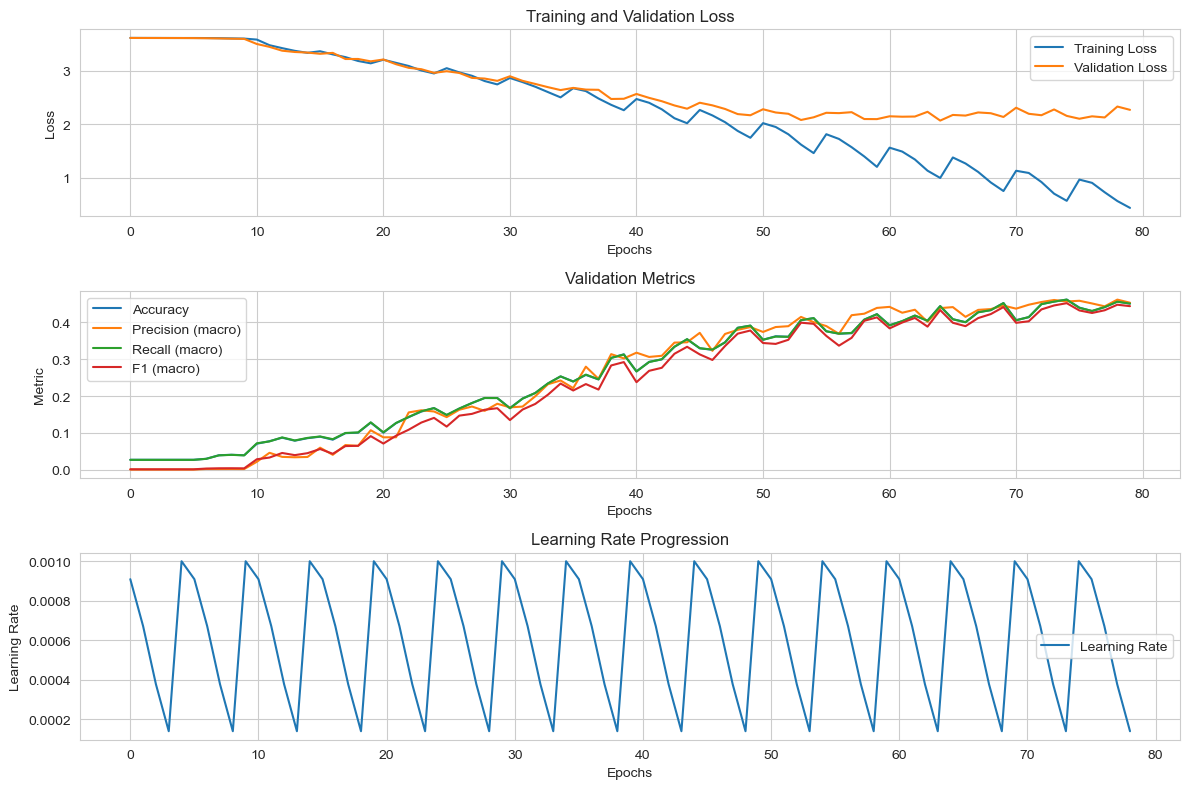

 60%|██████    | 3/5 [1:53:51<1:20:26, 2413.16s/it]

[2025-08-25 14:44:08]  Resetting GPU memory...
[2025-08-25 14:44:09]  Learning rate 5.00e-04 - eta_min 5.00e-05 - weight_decay 5.00e-04
[2025-08-25 14:44:17]  [0, 92/368] Loss: 3.6503
[2025-08-25 14:44:26]  [0, 184/368] Loss: 3.6306
[2025-08-25 14:44:34]  [0, 276/368] Loss: 3.6240
[2025-08-25 14:44:45]  New best model with Loss: 3.6107 at epoch 1
[2025-08-25 14:44:45]  
Epoch 1/100 - Training Loss: 3.6111 - Validation Loss: 3.6107 - Accuracy: 0.0272 - Precision (macro): 0.0007 - Recall (macro): 0.0270 - F1 (macro): 0.0014 - Time: 36.37s - Lr: 4.57e-04
[2025-08-25 14:44:54]  [1, 92/368] Loss: 3.6502
[2025-08-25 14:45:02]  [1, 184/368] Loss: 3.6306
[2025-08-25 14:45:11]  [1, 276/368] Loss: 3.6240
[2025-08-25 14:45:22]  New best model with Loss: 3.6106 at epoch 2
[2025-08-25 14:45:22]  
Epoch 2/100 - Training Loss: 3.6110 - Validation Loss: 3.6106 - Accuracy: 0.0272 - Precision (macro): 0.0007 - Recall (macro): 0.0270 - F1 (macro): 0.0014 - Time: 36.43s - Lr: 3.45e-04
[2025-08-25 14:45:30

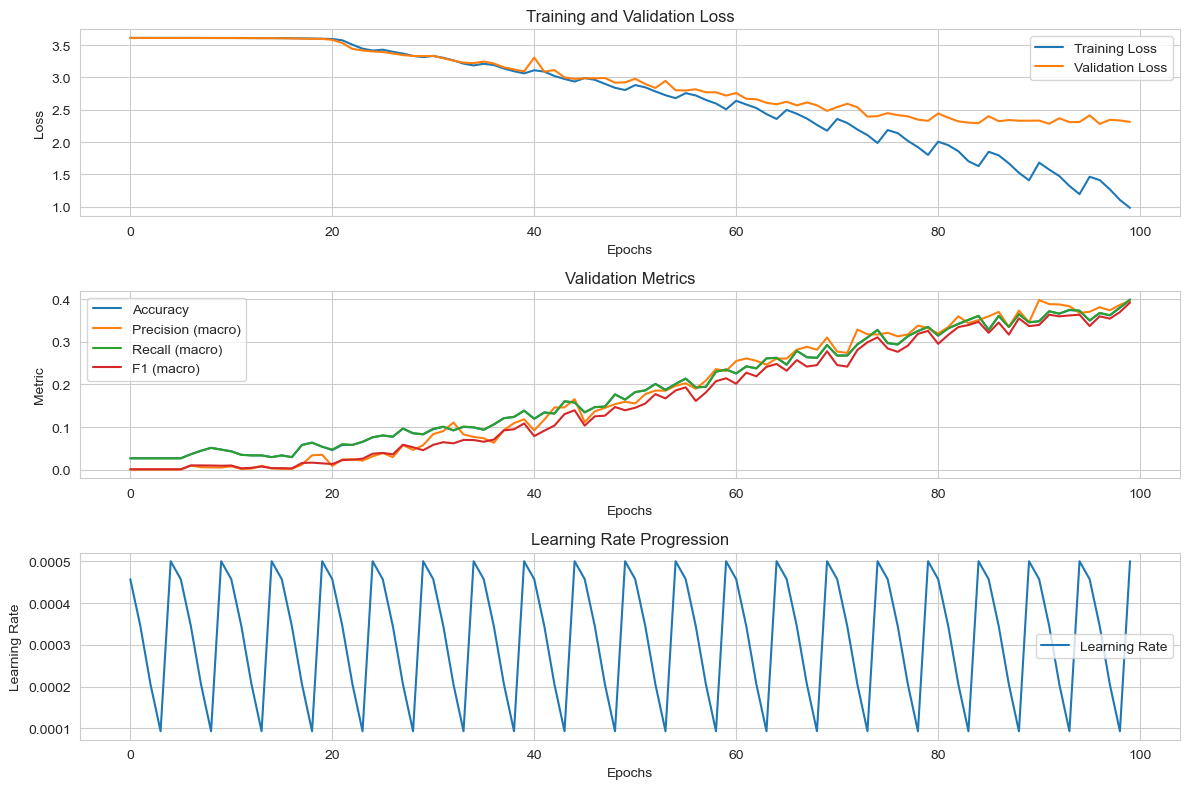

 80%|████████  | 4/5 [2:59:18<50:10, 3010.66s/it]  

[2025-08-25 15:49:35]  Resetting GPU memory...
[2025-08-25 15:49:35]  Learning rate 1.00e-04 - eta_min 1.00e-05 - weight_decay 5.00e-05
[2025-08-25 15:49:45]  [0, 92/368] Loss: 3.6505
[2025-08-25 15:49:54]  [0, 184/368] Loss: 3.6307
[2025-08-25 15:50:04]  [0, 276/368] Loss: 3.6241
[2025-08-25 15:50:17]  New best model with Loss: 3.6109 at epoch 1
[2025-08-25 15:50:17]  
Epoch 1/100 - Training Loss: 3.6110 - Validation Loss: 3.6109 - Accuracy: 0.0313 - Precision (macro): 0.0016 - Recall (macro): 0.0313 - F1 (macro): 0.0029 - Time: 41.28s - Lr: 9.14e-05
[2025-08-25 15:50:26]  [1, 92/368] Loss: 3.6501
[2025-08-25 15:50:35]  [1, 184/368] Loss: 3.6305
[2025-08-25 15:50:44]  [1, 276/368] Loss: 3.6240
[2025-08-25 15:50:56]  New best model with Loss: 3.6109 at epoch 2
[2025-08-25 15:50:56]  
Epoch 2/100 - Training Loss: 3.6110 - Validation Loss: 3.6109 - Accuracy: 0.0313 - Precision (macro): 0.0018 - Recall (macro): 0.0313 - F1 (macro): 0.0032 - Time: 39.34s - Lr: 6.89e-05
[2025-08-25 15:51:06

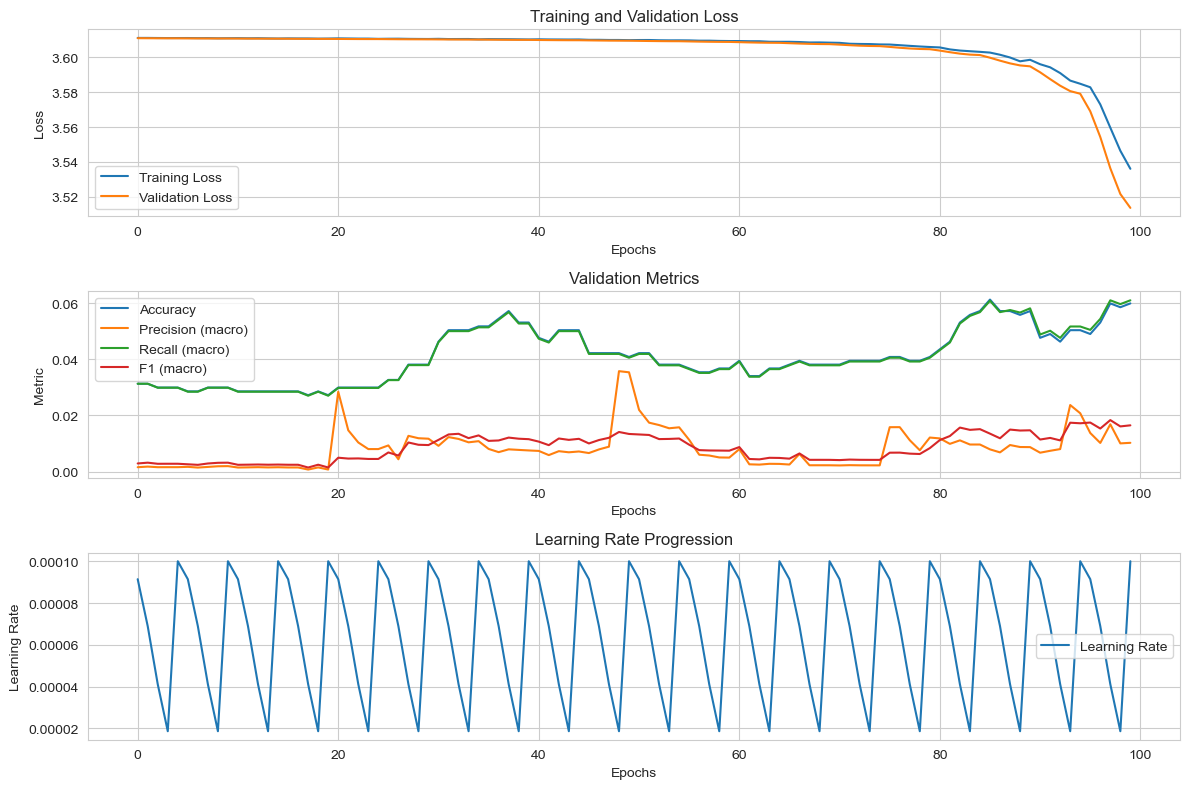

100%|██████████| 5/5 [4:01:35<00:00, 2899.20s/it]

[2025-08-25 16:51:53]  Resetting GPU memory...


In [61]:
best_AlexNet_model, AlexNet_results = hyperparameter_tuning(AlexNet, param_grid, epochs, train_dataloader, validation_dataloader, AlexNet_results, model_name="AlexNet")

In [40]:
import pandas as pd


results_df = pd.DataFrame(AlexNet_results)
results_df["val_loss"] = results_df["val_loss"].astype(float)
results_df = results_df.sort_values(by="val_loss").reset_index(drop=True)
print(results_df)

[2025-08-21 10:59:06]         lr  eta_min  weight_decay  val_loss  val_accuracy  val_precision_macro  \
0  0.0100  0.00010       0.00001  0.256611      0.894737             0.894574   
1  0.0050  0.00010       0.00001  0.279063      0.887218             0.887037   
2  0.0010  0.00005       0.00001  0.794284      0.624060             0.634806   
3  0.0005  0.00005       0.00001  1.029793      0.503759             0.543411   
4  0.0001  0.00001       0.00050  1.097296      0.330827             0.110276   

   val_recall_macro  val_f1_macro  
0          0.895118      0.894620  
1          0.887542      0.887215  
2          0.624242      0.614544  
3          0.503199      0.487573  
4          0.333333      0.165725  


# VGG

In [41]:
param_grid = {
    "lr":       [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    "eta_min":  [1e-4, 1e-4, 5e-5, 5e-5, 1e-5],
    "weight_decay": [5e-4, 1e-5, 5e-5]
}


total_combination = len(param_grid['lr'])
epochs = 100
time_per_epoch = 10 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-08-21 10:59:06]  Total time to hyper tune: 0.42 hours


In [42]:
VGG_results = []

In [ ]:
best_VGG_model, VGG_results = hyperparameter_tuning(VGG, param_grid, epochs, train_dataloader, validation_dataloader, VGG_results, model_name="vgg")

In [44]:
import pandas as pd

results_df = pd.DataFrame(VGG_results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="val_loss", inplace=True)
print(results_df)

[2025-08-21 11:26:44]         lr  eta_min  weight_decay  val_loss  val_accuracy  val_precision_macro  \
1  0.0050  0.00010       0.00005  0.311683      0.857143             0.859864   
2  0.0010  0.00005       0.00005  0.624768      0.729323             0.750072   
3  0.0005  0.00005       0.00005  0.643215      0.706767             0.706262   
4  0.0001  0.00001       0.00050  0.805105      0.661654             0.665377   
0  0.0100  0.00010       0.00050  1.030832      0.466165             0.466667   

   val_recall_macro  val_f1_macro  
1          0.858418      0.853315  
2          0.728956      0.726412  
3          0.707239      0.705452  
4          0.661616      0.661585  
0          0.466667      0.448246  


# MLP Mixer

In [23]:
param_grid = {
    "lr":       [1e-2, 5e-3, 1e-3, 5e-4, 1e-4],
    "eta_min":  [1e-4, 1e-4, 5e-5, 5e-5, 1e-5],
    "weight_decay": [5e-4, 1e-5, 5e-5]
}

total_combination = len(param_grid['lr'])
epochs = 100
time_per_epoch = 60 # approx

print(f"Total time to hyper tune: {total_combination * epochs * time_per_epoch / 3600:.2f} hours")

[2025-08-26 09:24:23]  Total time to hyper tune: 8.33 hours


In [21]:
MLP_Mixer_results = []

In [22]:
best_MLP_Mixer_model, MLP_Mixer_results = hyperparameter_tuning(MLPMixer, param_grid, epochs, train_dataloader, validation_dataloader, MLP_Mixer_results, model_name="mlp-mixer")

  0%|          | 0/5 [00:00<?, ?it/s]

[2025-08-26 09:23:03]  Learning rate 1.00e-02 - eta_min 1.00e-04 - weight_decay 5.00e-05
[2025-08-26 09:23:19]  [0, 92/368] Loss: 3.7549
[2025-08-26 09:23:33]  [0, 184/368] Loss: 3.6320
[2025-08-26 09:23:48]  [0, 276/368] Loss: 3.5654
[2025-08-26 09:24:06]  New best model with Loss: 3.3372 at epoch 1
[2025-08-26 09:24:06]  
Epoch 1/100 - Training Loss: 3.5108 - Validation Loss: 3.3372 - Accuracy: 0.1007 - Precision (macro): 0.0607 - Recall (macro): 0.1006 - F1 (macro): 0.0528 - Time: 63.05s - Lr: 9.05e-03


  0%|          | 0/5 [01:09<?, ?it/s]

[2025-08-26 09:24:12]  Resetting GPU memory...


KeyboardInterrupt: 

In [50]:
import pandas as pd

results_df = pd.DataFrame(MLP_Mixer_results)
results_df.fillna("", inplace=True)
results_df.sort_values(by="val_loss", inplace=True)
print(results_df)

[2025-08-21 12:08:44]         lr  eta_min  weight_decay  val_loss  val_accuracy  val_precision_macro  \
0  0.0100  0.00010       0.00001  0.546432      0.751880             0.751542   
1  0.0050  0.00010       0.00001  0.576167      0.751880             0.756914   
2  0.0010  0.00005       0.00001  0.697021      0.706767             0.710924   
3  0.0005  0.00005       0.00005  0.771009      0.676692             0.677641   
4  0.0001  0.00001       0.00050  0.951660      0.578947             0.589116   

   val_recall_macro  val_f1_macro  
0          0.752020      0.750916  
1          0.751684      0.751306  
2          0.706566      0.705947  
3          0.677441      0.675263  
4          0.580640      0.570070  


f# View wrong classified images

In [56]:
import torch
import os
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image


criterion = nn.CrossEntropyLoss()

# Ensure evaluation mode
tested_model = AlexNet(num_classes=37)
tested_model.load_state_dict(torch.load("models/AlexNetlr=0.01+eta_min=0.0001+weight_decay=1e-05.pt"))
tested_model.to(device)
tested_model.eval()
validation_loss = 0.0
all_labels = []  # Ground truth labels for validation
all_preds = []  # Predictions for validation

# Directory to save misclassified images
misclassified_dir = "misclassified_images_AlexNet"
os.makedirs(misclassified_dir, exist_ok=True)

misclassified_samples = []  # Store tuples of (image path, predicted label, true label)

# Define the inverse transform
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1)
std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1)

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(validation_dataloader):
        images, labels = images.to(device), labels.to(device).long()

        logits = tested_model(images)  # Forward pass (logits)
        loss = criterion(logits, labels)  # Compute validation loss
        validation_loss += loss.item()

        preds = torch.argmax(logits, dim=1)

        # Identify misclassified images
        incorrect_indices = (preds != labels).cpu().numpy().astype(bool)
        incorrect_images = images[incorrect_indices]
        incorrect_preds = preds[incorrect_indices].cpu().numpy()
        incorrect_labels = labels[incorrect_indices].cpu().numpy()

        # Reverse normalization
        incorrect_images = incorrect_images.cpu() * std + mean  # Unnormalize

        # Save misclassified images
        for i, (img, pred_label, true_label) in enumerate(zip(incorrect_images, incorrect_preds, incorrect_labels)):
            img_pil = to_pil_image(img.clamp(0, 1))  # Convert tensor to PIL image
            filename = f"{misclassified_dir}/batch{batch_idx}_img{i}_pred{int(pred_label)}_true{int(true_label)}.png"
            img_pil.save(filename)
            misclassified_samples.append((filename, pred_label, true_label))

# Print misclassified images with their labels
print("Misclassified Images:")
for filename, pred_label, true_label in misclassified_samples:
    print(f"{filename} -> Predicted: {pred_label}, True: {true_label}")

[2025-08-21 14:46:56]  Misclassified Images:
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch0_img0_pred2_true0.png -> Predicted: 2, True: 0
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch0_img1_pred1_true0.png -> Predicted: 1, True: 0
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch1_img0_pred1_true0.png -> Predicted: 1, True: 0
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch2_img0_pred0_true1.png -> Predicted: 0, True: 1
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch2_img1_pred2_true1.png -> Predicted: 2, True: 1
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch4_img0_pred2_true1.png -> Predicted: 2, True: 1
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch4_img1_pred2_true1.png -> Predicted: 2, True: 1
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch5_img0_pred0_true1.png -> Predicted: 0, True: 1
[2025-08-21 14:46:56]  misclassified_images_AlexNet/batch5_img1_pred0_true1.png -> Predicted: 0, True: 1
[2025-08-2